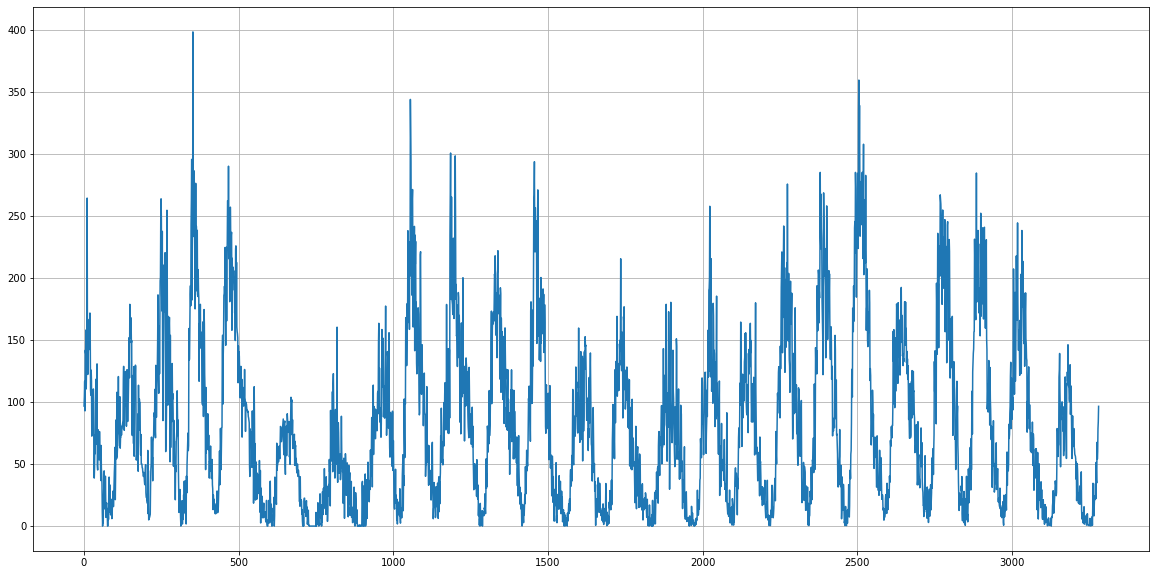

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from pmdarima import model_selection
import ipywidgets as widgets

forecast_periods = 100
test_forecast_periods = 150
epochs_num = 200
window_size = 24
batch_size = 32
shuffle_buffer_size = 1000

# download the data
df = pd.read_json('observed-solar-cycle-indices.json')
ssn_data = df.ssn
ssn_data = ssn_data.values.reshape(-1, 1)

plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(ssn_data)
plt.show()

In [2]:
split_time = len(ssn_data) - test_forecast_periods
train, test = model_selection.train_test_split(ssn_data, train_size=split_time)

In [3]:
def make_and_fit_model(lookback_window, num_forecast, model_data, epochs):
    # scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(model_data)
    transformed_data = scaler.transform(model_data)

    # setup data for lookback window
    X_data = []
    Y_data = []

    for i in range(lookback_window, len(transformed_data) - num_forecast + 1):
        X_data.append(transformed_data[i - lookback_window: i])
        Y_data.append(transformed_data[i: i + num_forecast])

    X_data = np.array(X_data)
    Y_data = np.array(Y_data)

    # making a model and adding the layers
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(lookback_window, 1)))
    model.add(LSTM(units=50))
    model.add(Dense(num_forecast))

    # setup model compile and fit
    model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=["mae"])
    model.fit(X_data, Y_data, epochs=epochs, batch_size=batch_size, verbose=True)

    # generate the forecasts
    X_forecast_data = transformed_data[- lookback_window:]
    X_forecast_data = X_forecast_data.reshape(1, lookback_window, 1)

    # run model predict
    Y_forecast_data = model.predict(X_forecast_data).reshape(-1, 1)

    # inverse transform data with scaler
    Y_forecast_data = scaler.inverse_transform(Y_forecast_data)

    return Y_forecast_data

# Mean Absolute Error
def mae(true_values, predictions):
    true_values = np.array(true_values)
    predictions = np.array(predictions)
    return np.mean(np.abs(true_values - predictions))

# Symmetric Mean Absolut Percent Error
def smape(true_values, predictions):
    return 1 / len(true_values) * np.sum(2 * np.abs(predictions - true_values) / (np.abs(true_values) + np.abs(predictions)) * 100)


import ipywidgets as widgets

selector = widgets.RadioButtons(
    options=['The color', 'The length', 'The slope'],
    value=None,
    description='',
    disabled=False
)

button = widgets.Button(
    description='Submit answer',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)

def evaluate(button):

    selection = selector.get_interact_value()

    if (selection == "The slope"):
        print("Correct!")
    else:
        print("Try again...")
        # To reset the option value. However, I would like to avoid having a "default" value
        selector.value = None

button.on_click(evaluate)

left_box = widgets.VBox([selector, button])
widgets.HBox([left_box])

2022-06-22 15:08:57.899188: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
93/93 [==============================] - 5s 27ms/step - loss: 0.0172 - mae: 0.1439
Epoch 2/200
93/93 [==============================] - 3s 29ms/step - loss: 0.0115 - mae: 0.1178
Epoch 3/200
93/93 [==============================] - 2s 24ms/step - loss: 0.0095 - mae: 0.1042
Epoch 4/200
93/93 [==============================] - 2s 23ms/step - loss: 0.0093 - mae: 0.1025
Epoch 5/200
93/93 [==============================] - 2s 24ms/step - loss: 0.0091 - mae: 0.1010
Epoch 6/200
93/93 [==============================] - 2s 25ms/step - loss: 0.0092 - mae: 0.1016
Epoch 7/200
93/93 [==============================] - 2s 22ms/step - loss: 0.0090 - mae: 0.1001
Epoch 8/200
93/93 [==============================] - 2s 23ms/step - loss: 0.0090 - mae: 0.1000
Epoch 9/200
93/93 [==============================] - 2s 25ms/step - loss: 0.0089 - mae: 0.0995
Epoch 10/200
93/93 [==============================] - 2s 23ms/step - loss: 0.0089 - mae: 0.0989
Epoch 11/200
93/93 [=============================

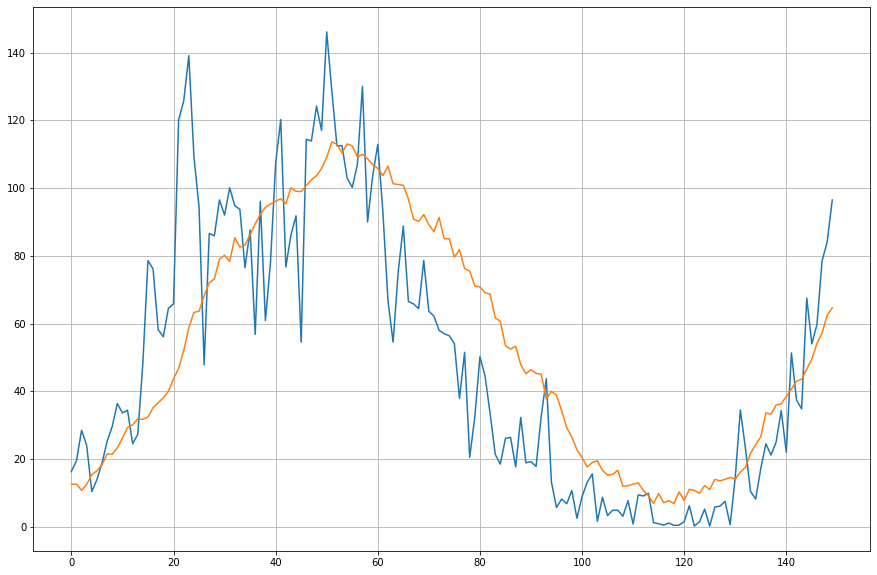

In [4]:

test_prediction = make_and_fit_model(window_size, test_forecast_periods, train, epochs_num)

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(test)
plt.plot(test_prediction)
plt.show()

In [5]:
print('mae: ',mae(test, test_prediction))
print(smape(test, test_prediction))

# 19, 57 - huber, adamax
# 45, 146 - huber, adagrad
# 14, 55 - huber, adam
# 18, 58 - mean_squared_error, adam
# 17, 54 - mean_squared_error, adamax

mae:  17.722820302963257
54.68284942007466


Epoch 1/200
99/99 [==============================] - 5s 20ms/step - loss: 0.0169 - mae: 0.1437
Epoch 2/200
99/99 [==============================] - 2s 16ms/step - loss: 0.0105 - mae: 0.1122
Epoch 3/200
99/99 [==============================] - 2s 23ms/step - loss: 0.0091 - mae: 0.1017
Epoch 4/200
99/99 [==============================] - 2s 18ms/step - loss: 0.0089 - mae: 0.1005
Epoch 5/200
99/99 [==============================] - 2s 21ms/step - loss: 0.0087 - mae: 0.0993
Epoch 6/200
99/99 [==============================] - 2s 20ms/step - loss: 0.0087 - mae: 0.0987
Epoch 7/200
99/99 [==============================] - 2s 20ms/step - loss: 0.0087 - mae: 0.0985
Epoch 8/200
99/99 [==============================] - 2s 18ms/step - loss: 0.0086 - mae: 0.0977
Epoch 9/200
99/99 [==============================] - 2s 18ms/step - loss: 0.0085 - mae: 0.0970
Epoch 10/200
99/99 [==============================] - 2s 18ms/step - loss: 0.0084 - mae: 0.0964
Epoch 11/200
99/99 [=============================

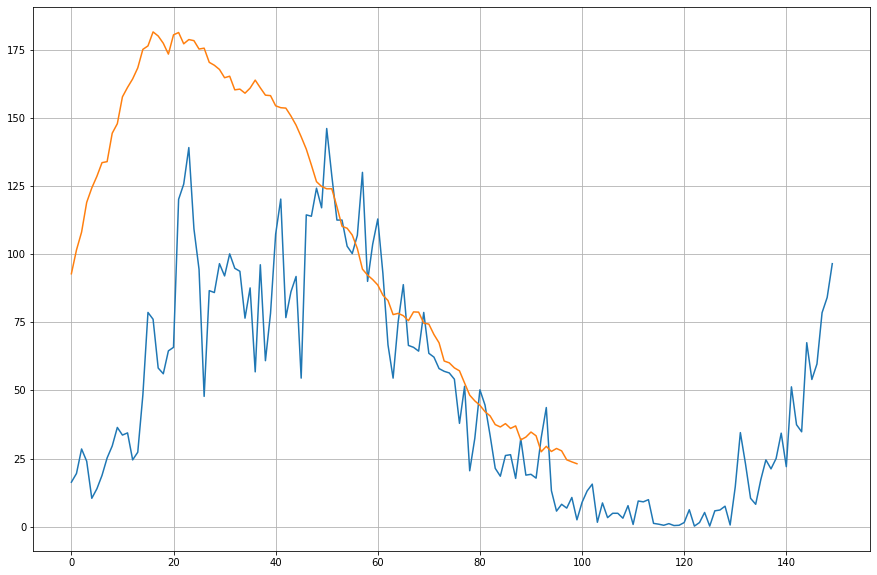

In [9]:
# prediction for the next X months
test_prediction = make_and_fit_model(window_size, forecast_periods, ssn_data, epochs_num)

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(test_prediction)
plt.show()

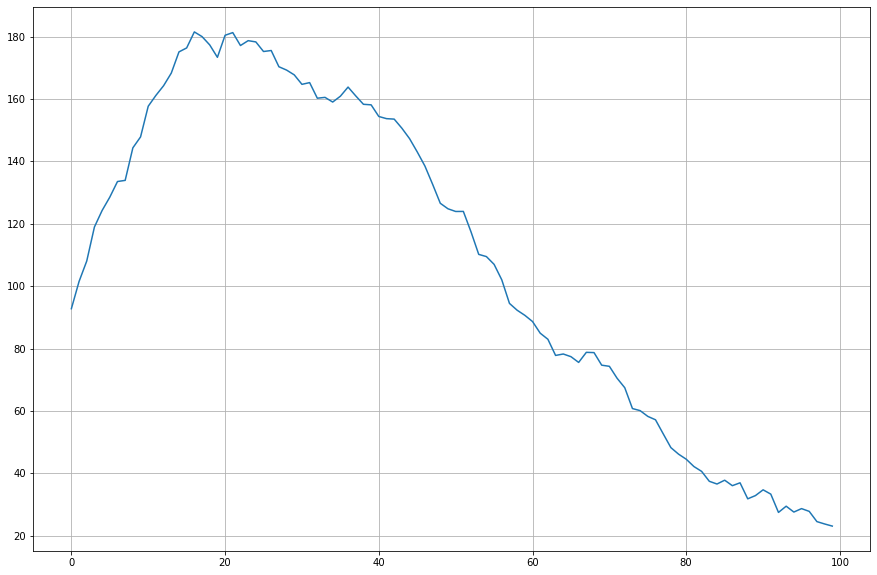

In [10]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(test_prediction)
plt.show()

In [7]:
# # generate the forecasts
# X_forecast_data = transformed_data[- num_lookback:]  # last available input sequence
# X_forecast_data = X_forecast_data.reshape(1, num_lookback, 1)
#
# Y_forecast_data = model.predict(X_forecast_data).reshape(-1, 1)
# print('Y_ before transform', Y_forecast_data)
# Y_forecast_data = scaler.inverse_transform(Y_forecast_data)
# print('Y_ after transform', Y_forecast_data)
#
# print('X_', X_forecast_data)

In [8]:
# plt.figure(figsize=(15,10))
# plt.grid(True)
# plt.plot(Y_forecast_data)
# plt.show()

In [6]:
# FORECAST:



# # scale the data
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = scaler.fit(ssn_data)
# transformed_data = scaler.transform(ssn_data)
#
# # generate the input and output sequences
# num_lookback = 60  # length of input sequences (lookback period)
# num_forecast = forecast_periods  # length of output sequences (forecast period)
#
# X_data = []
# Y_data = []
#
# for i in range(num_lookback, len(transformed_data) - num_forecast + 1):
#     X_data.append(transformed_data[i - num_lookback: i])
#     Y_data.append(transformed_data[i: i + num_forecast])
#
# X_data = np.array(X_data)
# Y_data = np.array(Y_data)
#
# print('X_data', X_data)
#
#
# # clear the session
# # tf.keras.backend.clear_session()
#
#
# # fit the model
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(num_lookback, 1)))
# model.add(LSTM(units=50))
# model.add(Dense(num_forecast))
#
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(X_data, Y_data, epochs=epochs_num, batch_size=32, verbose=True)